<font_size='17'>
<font face='Microsoft YaHei'>
## PSPNet测试效果

In [57]:
from __future__ import absolute_import
import datetime
import os
import random
os.environ['CUDA_VISIBLE_DEVICES']="3"
import torchvision.utils as vutils
from tensorboard import SummaryWriter
from torch import optim
from torch.autograd import Variable
from torch.backends import cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import sys
sys.path.append('..')
import utils.transforms as extended_transforms
import torchvision.transforms as standard_transforms
from datasets import LIP
from models import *
from utils import check_mkdir, evaluate, AverageMeter, CrossEntropyLoss2d
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
cudnn.benchmark = True 

ckpt_path = '../checkpoints/'
exp_name = 'lip-psp_net'

In [54]:
net = PSPNet(num_classes=LIP.num_classes).cuda()

mean_std =([0.485,0.456,0.406], [0.229,0.224,0.225])
val_input_transform = standard_transforms.Compose([
    standard_transforms.ToTensor(),
    standard_transforms.Normalize(*mean_std)
    ])
target_transform = extended_transforms.MaskToTensor()
val_set = LIP.LIP('val',transform = val_input_transform,target_transform=target_transform)
val_loader = DataLoader(val_set, batch_size=1,num_workers =8, shuffle=False)


In [72]:
snapshot ='epoch_1_loss_0.90124_acc_0.73181_acc-cls_0.30802_mean-iu_0.24672_fwavacc_0.57170_lr_0.0038416895.pth'
print('inference from'+ ckpt_path+ snapshot)
net.load_state_dict(torch.load(os.path.join(ckpt_path,exp_name,snapshot)))

net.eval()

inference from../checkpoints/epoch_1_loss_0.90124_acc_0.73181_acc-cls_0.30802_mean-iu_0.24672_fwavacc_0.57170_lr_0.0038416895.pth


PSPNet(
  (layer0): Sequential(
    (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
 

In [93]:
dataiter =iter(val_loader)
inputs, gts = dataiter.next()
N = inputs.size(0)
print(inputs.size())
in2,gt2 = dataiter.next()

torch.Size([1, 3, 423, 187])


In [35]:
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [64]:
# show a 4D tensor image
def imshow(img):
    image = img.squeeze(0)    # squeeze
    
    trans=DeNormalize(*mean_std)   # DeNormalize
    image = trans(image).numpy().transpose((1,2,0))   # tensor->numpy
    plt.imshow(image)   

In [97]:
def predict(inputs):
    print(inputs.size())
    inputs=Variable(inputs,volatile=True).cuda()
    outputs=net(inputs)
    prediction = outputs.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
    prediction = LIP.colorize_mask(prediction)
    plt.imshow(prediction)

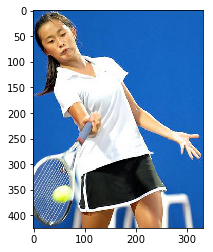

torch.Size([1, 3, 425, 331])


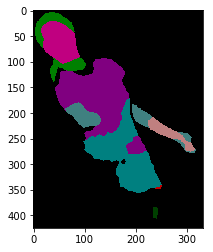

In [104]:
img_tensor, gts = dataiter.next()
imshow(img_tensor)
plt.show()
predict(img_tensor)
plt.show()